In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo


This notebook shows how to implement the delayed match-to-sample task using an LMU.

We start by generating the stimulus data and desired target

In [2]:
n_trials_per_condition = 5  # x 8 stim_locs x 2 match-or-mismatch
rng_seed = 1337
isi_dur = 1.0
cue_dur = 0.5
delay1_dur = 1.5
sample_dur = 0.5
delay2_dur= 1.5
response_dur = 1.0
stim_x, stim_y = 1/np.sqrt(2), 1/np.sqrt(2)

phase_durs = [isi_dur, cue_dur, delay1_dur, sample_dur, delay2_dur, response_dur]
cumulative_durs = np.cumsum(phase_durs)
trial_dur = cumulative_durs[-1]

# Fixation point acts as a hold signal. We'll just use a 1-d value: -1 for hold, +1 for go.
def hold_signal(t):
    return 1 - 1 * ((t % trial_dur) < np.sum(cumulative_durs[-2]))

# Visual stimulus location: x, y. Will be 0, 0 except during Cue and Sample
# periods. During Cue it will be set to one of 8 possible values:
cue_locs = np.array([[-stim_x,  stim_y], [0.0,  stim_y], [stim_x, stim_y],
                     [-stim_x,     0.0],                 [stim_x,    0.0],
                     [-stim_x, -stim_y], [0.0, -stim_y], [stim_x, -stim_y]])
n_locs = len(cue_locs)
trial_conds = np.tile(np.arange(n_locs * 2), n_trials_per_condition)
rng = np.random.default_rng(seed=rng_seed)
rng.shuffle(trial_conds)

def targ_signal(t):
    trial_ix = int(np.floor(t / trial_dur)) % len(trial_conds)
    t_trial = t % trial_dur
    is_cue = t_trial >= cumulative_durs[0] and t_trial < cumulative_durs[1]
    is_samp = (not is_cue) and t_trial >= cumulative_durs[2] and t_trial < cumulative_durs[3]
    if is_cue or is_samp:
        cond_ix = trial_conds[trial_ix]
        cue_loc = cue_locs[cond_ix % n_locs]
        if not is_samp:
            return cue_loc
        samp_sign = 1 - 2 * (cond_ix >= n_locs)
        return samp_sign * cue_loc
    return [0, 0]

def expected_response(t):
    trial_ix = int(np.floor(t / trial_dur)) % len(trial_conds)
    t_trial = t % trial_dur
    if t_trial >= cumulative_durs[-2]:
        cond_ix = trial_conds[trial_ix]
        return 1 - 2 * (cond_ix >= n_locs)
    return 0

Here's what those look like

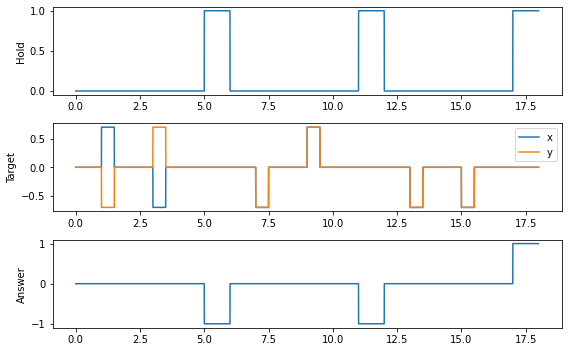

In [3]:
test_trials = 3
test_srate = 1000  # Hz
t_vec = np.arange(0, trial_dur * test_trials, 1 / test_srate)

plt.figure(figsize=(8, 5))
plt.subplot(3, 1, 1)
plt.plot(t_vec, hold_signal(t_vec))
plt.ylabel('Hold')
plt.subplot(3, 1, 2)
plt.plot(t_vec, [targ_signal(_) for _ in t_vec])
plt.ylabel('Target')
plt.legend(['x', 'y'], loc='upper right')
plt.subplot(3, 1, 3)
plt.plot(t_vec, [expected_response(_) for _ in t_vec])
plt.ylabel('Answer')
plt.tight_layout()

Now we need to buld a network that takes the Target as input and outputs the Answer.

We'll do this with an LMU (Legendre Memory Unit).  The standard way to express an LMU is a linear "Legendre Delay Network" (LDN) followed by a standard neural network non-linear layer.  There are optional connections between the LDN and the non-linear layer, but let's be very simple and just have a purely feed-forward system.  The only recurrence in this version is in the linear LDN.  (Note: later in this notebook we'll move the recurrence to the neurons so that it's just one recurrent network doing everything)

Here's a quick implementation of the LDN using a Nengo `Process`, which is a slightly fancier way of configuring a `Node`.

In [4]:
import scipy.linalg
from scipy.special import legendre

class LDN(nengo.Process):
    def __init__(self, theta, q, size_in=1):
        self.q = q              # number of internal state dimensions per input
        self.theta = theta      # size of time window (in seconds)
        self.size_in = size_in  # number of inputs

        # Do Aaron's math to generate the matrices
        #  https://github.com/arvoelke/nengolib/blob/master/nengolib/synapses/analog.py#L536
        Q = np.arange(q, dtype=np.float64)
        R = (2*Q + 1)[:, None] / theta
        j, i = np.meshgrid(Q, Q)

        self.A = np.where(i < j, -1, (-1.)**(i-j+1)) * R
        self.B = (-1.)**Q[:, None] * R

        super().__init__(default_size_in=size_in, default_size_out=q*size_in)

    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        state = np.zeros((self.q, self.size_in))

        # Handle the fact that we're discretizing the time step
        #  https://en.wikipedia.org/wiki/Discretization#Discretization_of_linear_state_space_models
        Ad = scipy.linalg.expm(self.A*dt)
        Bd = np.dot(np.dot(np.linalg.inv(self.A), (Ad-np.eye(self.q))), self.B)

        # this code will be called every timestep
        def step_legendre(t, x, state=state):
            state[:] = np.dot(Ad, state) + np.dot(Bd, x[None, :])
            return state.T.flatten()
        return step_legendre

Now we build our network and run it for a while, recording the data from the neurons.  We'll use that data to compute decoders for the output we want.

In [5]:
ens_seed = 1337

model = nengo.Network()
with model:
    stim = nengo.Node(targ_signal)
    
    ldn = nengo.Node(LDN(theta=6.0, q=6, size_in=2))
    
    ens = nengo.Ensemble(n_neurons=3000, dimensions=ldn.output.q*2, seed=ens_seed)
    nengo.Connection(ldn, ens)
    nengo.Connection(stim, ldn, synapse=None)
    
    p_ens = nengo.Probe(ens.neurons)
    
    ideal = nengo.Node(expected_response)
    p_ideal = nengo.Probe(ideal)

    
sim = nengo.Simulator(model)
sim.run(72)



HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [6]:
filt = nengo.synapses.Lowpass(0.01)
A = filt.filt(sim.data[p_ens])
T = filt.filt(sim.data[p_ideal])

# Since there's a lot of data here, let's use a fancier least-squares solver.
#  This should run much faster than the default for this case.
import nengo.utils.least_squares_solvers as lss
dec, info = nengo.solvers.LstsqL2(solver=lss.LSMRScipy())(A, T)



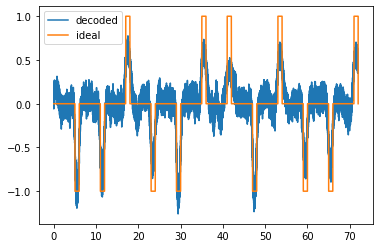

In [7]:
plt.plot(sim.trange(), A.dot(dec), label='decoded')
plt.plot(sim.trange(), sim.data[p_ideal], label='ideal')
plt.legend()
plt.show()

That seems like a pretty good decoder.  Let's build our network again, using that decoder, and run it for longer so we see how it generalizes to other cases.

In [8]:
model = nengo.Network()
with model:
    stim = nengo.Node(targ_signal)
    
    ldn = nengo.Node(LDN(theta=6.0, q=6, size_in=2))
    
    ens = nengo.Ensemble(n_neurons=3000, dimensions=ldn.output.q*2, seed=ens_seed)
    nengo.Connection(ldn, ens)
    nengo.Connection(stim, ldn, synapse=None)
    
    output = nengo.Node(None, size_in=1)
    nengo.Connection(ens.neurons, output, transform=dec.T)
    
    p_ens = nengo.Probe(ens.neurons)
    
    ideal = nengo.Node(expected_response)
    p_ideal = nengo.Probe(ideal)
    p_output = nengo.Probe(output, synapse=0.03)

    
sim = nengo.Simulator(model)
sim.run(144)



HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

Text(110, 1.1, 'TESTING')

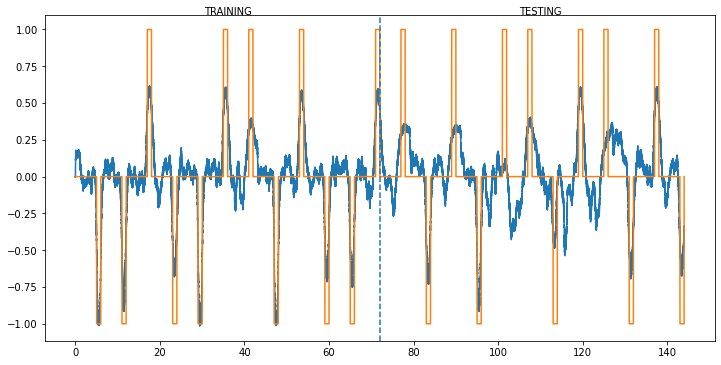

In [9]:
plt.figure(figsize=(12,6))
plt.plot(sim.trange(), sim.data[p_output])
plt.plot(sim.trange(), sim.data[p_ideal])
plt.axvline(72, ls='--')
plt.text(36, 1.1, 'TRAINING', ha='center')
plt.text(36+74, 1.1, 'TESTING', ha='center')

Awesome!  That seems to generalize pretty well.  More training examples might help, but it's still doing a pretty good job.  We might want to try seeing how varying the number of neurons in the non-linearity affects things.  There's also the `q` parameter in the LDN to vary.

However, there's another big change we might want to make.  With the network as defined above, the recurrence is not done with neurons.  It's just done in math, with this simple linear calculation happening before the neurons.  This may be what we want to do if we're just interested in efficiency on traditional hardware.  But, we can also re-organize our network such that we recurrently connect the neurons to approximate the differential equation of the LDN.  We do this using the NEF trick for approximating any differential equation using neurons.  Importantly, we can then use those exact same neurons for the readout, so we only have one group of neurons in our final model.

The basic LDN differential equation is ${{dm} \over {dt}} = Am+Bu$ and the LDN code above computes those $A$ and $B$ matrices for us.  However, those matrices are for the case of 1 dimensional input.  In this case we actually have 2 dimensions being input, and the LDN just treats that as two separate LDNs.  If we want to write all of that as one giant differential equation of $2q$ dimensions, then we need to make new A and B matrices that just have copies of the old A and B matrices along the diagonal.

In [10]:
ldn = LDN(theta=6.0, q=6, size_in=2)
B_full = np.zeros((ldn.q*2, 2))
A_full = np.zeros((ldn.q*2, ldn.q*2))
for i in range(2):
    B_full[ldn.q*i:ldn.q*(i+1),i:i+1] = ldn.B
    A_full[ldn.q*i:ldn.q*(i+1),ldn.q*i:ldn.q*(i+1)] = ldn.A


Now we define our neural network with just one recurrence, and we use the NEF trick of computing $\tau g(u)$ on the input and $\tau f(x)+x$ on the recurrent connection to give a resulting network that approximates ${{dx} \over {dt}} = f(x)+g(u)$.

In the ideal case, we could just use the decoders that we've previously computed to use with this network.  However, it's only going to be approximating that differential equation, and so any differences may change the result.  So let's re-do the training.

In [11]:
ens_seed = 1337

model = nengo.Network()
with model:
    stim = nengo.Node(targ_signal)
        
    ens = nengo.Ensemble(n_neurons=3000, dimensions=ldn.q*2, seed=ens_seed)
    tau = 0.1
    
    nengo.Connection(stim, ens, transform=B_full*tau, synapse=tau)
    nengo.Connection(ens, ens, synapse=tau, transform=A_full*tau+np.eye(ldn.q*2))
    
    p_ens = nengo.Probe(ens.neurons)
    
    ideal = nengo.Node(expected_response)
    p_ideal = nengo.Probe(ideal)

    
sim = nengo.Simulator(model)
sim.run(72)



HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [12]:
filt = nengo.synapses.Lowpass(0.01)
A = filt.filt(sim.data[p_ens])
T = filt.filt(sim.data[p_ideal])
import nengo.utils.least_squares_solvers as lss
dec, info = nengo.solvers.LstsqL2(solver=lss.LSMRScipy())(A, T)



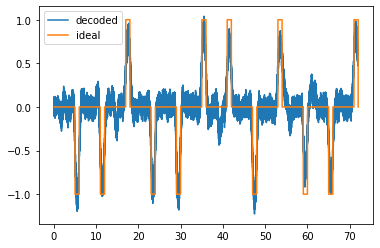

In [14]:
plt.plot(sim.trange(), A.dot(dec), label='decoded')
plt.plot(sim.trange(), sim.data[p_ideal], label='ideal')
plt.legend()
plt.show()

And let's see how the resulting network generalizes.

In [15]:
ens_seed = 1337

model = nengo.Network()
with model:
    stim = nengo.Node(targ_signal)
    
    ens = nengo.Ensemble(n_neurons=3000, dimensions=ldn.q*2, seed=ens_seed)
    tau = 0.1
    
    nengo.Connection(stim, ens, transform=B_full*tau, synapse=tau)
    nengo.Connection(ens, ens, synapse=tau, transform=A_full*tau+np.eye(ldn.q*2))
    
    output = nengo.Node(None, size_in=1)
    nengo.Connection(ens.neurons, output, transform=dec.T)    
    
    p_ens = nengo.Probe(ens.neurons)
    
    ideal = nengo.Node(expected_response)
    p_ideal = nengo.Probe(ideal)
    p_output = nengo.Probe(output, synapse=0.03)

    
sim = nengo.Simulator(model)
sim.run(144)



HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

Text(110, 1.1, 'TESTING')

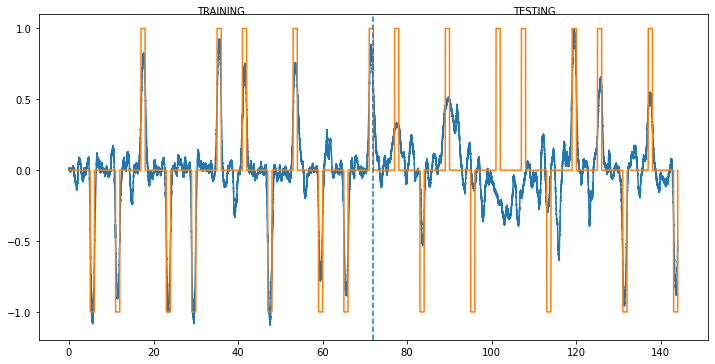

In [16]:
plt.figure(figsize=(12,6))
plt.plot(sim.trange(), sim.data[p_output])
plt.plot(sim.trange(), sim.data[p_ideal])
plt.axvline(72, ls='--')
plt.text(36, 1.1, 'TRAINING', ha='center')
plt.text(36+74, 1.1, 'TESTING', ha='center')

It's not quite as good, but we'd need to do more testing to see if that's a statistically significant difference.  We should also consider whether we need to adjust the radius of the ensemble, to make sure aren't going outside that range.  

We could also look at adjusting the task the network needs to compute a bit.  In this case, the network is trying to learn everything about the task, including when to produce the answer.  For example, if some other (hand-designed) network was responsible for gating the output so that it only responds when it is supposed to, then we could adjust the training to only the points where the output is given (i.e. it's just trying to match the +1 and -1 outputs, not also trying to produce 0 the rest of the time).  This should be easier to do.